# Normalización por lote (Batch Normalization)

Propuesto for [Ioffe & Szegedy](https://arxiv.org/pdf/1502.03167.pdf) es un método para acelerar el entrenamiento mediante la normalización de los valores de los pesos en cada región de la red neuronal. El libro de Deep Learning en el [capítulo de regularización](https://www.deeplearningbook.org/contents/regularization.html) hace un excelente trabajo de explicar el porqué se necesita y cómo se puede utilizar en redes neuronales convolucionales (CNN).

En este documento se expondrán las diferencias de entrenar una CNN con y sin normalización por lote (BN) para ver sus efectos en el entrenamiento de una CNN.

In [1]:
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.optimizers import Nadam, RMSprop, Adam
import matplotlib.pyplot as plt

Como siempre, se inicializan los hiperparámetros para el conjunto de datos en cuestión.

In [58]:
batch_size = 32
num_classes = 10
epocas = 20

In [59]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## CIFAR-10

En este documento se trabajará con el conjunto de datos [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), que es un conjunto de 60000 imágenes de tamaño $32 \times 32$, a color, y que contienen 10 clases diferentes. La información del conjunto de datos se puede ver en el sitio web vinculado anteriormente.

In [60]:
print("Tamaño de x_train:", x_train.shape)
print(x_train.shape[0], "Ejemplos de entrenamiento")
print(x_test.shape[0], "Ejemplos de prueba")

Tamaño de x_train: (50000, 32, 32, 3)
50000 Ejemplos de entrenamiento
10000 Ejemplos de prueba


Aquí se puede observar una de las imágenes, solamente para hacer un poco de exploración del conjunto de datos y conocerlo.

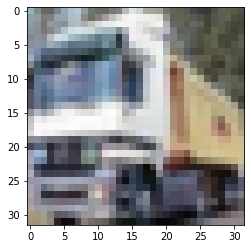

In [61]:
plt.imshow(x_train[1, :, :, :])

Como es costumbre, se cambia el tipo a `float32` y se normalizan los valores de las imágenes.

In [62]:
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

Adicionalmente, se cambian las etiquetas de las clases utilizando codificación _one hot._

In [63]:
# Convert class vectors to binary class matrices.
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

## Diseño básico (sin BN)

En este diseño no se va a incorporar BN. Este diseño fue tomado del [ejemplo de `keras`](https://keras.io/examples/cifar10_cnn/) para CNN y clasificación, pero modificado para su uso en este documento.

La arquitectura es la siguiente:

- La **primera** capa es de convolución con 32 unidades, con relleno de $3 \times 3$, y función de activación ReLU.
- La **segunda** capa también es de convolución con 32 unidades, sin relleno, y función de activación ReLU.
- A estas dos capas le sigue una capa de _max pooling_ de $2 \times 2$.
- La **tercera** capa es de convolución con 64 unidades, con relleno de $3 \times 3$, y función de activación ReLU.
- La **cuarta** capa también es de convolución con 64 unidades, sin relleno, y función de activación ReLU.
- A estas dos capas le sigue una nueva capa de _max pooling_ de $2 \times 2$; aquí termina la etapa de características
- Con la etapa de clasificación se **aplanan** las imágenes y se ingresan a una red neuronal totalmente conectada de 512 unidades con función de activación ReLU.
- La **capa de salida** tiene tantas unidades como clases y función de activación softmax.

In [64]:
arquitectura_basica = [
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3),
           padding="same",
           activation="relu",
           input_shape=x_train.shape[1:]),
    Conv2D(32, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3),
           padding="same",
           activation="relu"),
    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Capa totalmente conectada
    Flatten(),
    Dense(512, activation="relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

## Diseño normalizado (con BN)

En este diseño se incorpora BN. Este diseño es el mismo que el anterior, la única diferencia es que antes de cualquier función de activación se aplica la normalización, para alimentar a la función de activación con los valores normalizados.

Dos puntos importantes a mencionar:

- Se quita el **sesgo** de cada capa, siguiendo las recomendaciones del artículo original. Esto porque cuando se normalizan los valores de cada capa el sesgo se elimina en el proceso de normalización y no hace falta calcularlo.
- Se pone la opción `scale=False` dado que la media será calculada por la función de activación ReLU. En cualquier otro caso se debe de quitar esta opción dado que no siempre es cierta esta hipótesis.

In [65]:
# Todas las capas normalizadas, excpeto la última
arquitectura_norm = [
    # Capa de entrada, primera capa de características
    Conv2D(32, kernel_size=(3, 3),
           padding="same",
           input_shape=x_train.shape[1:],
           use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    Conv2D(32, (3, 3), use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Segunda capa de características
    Conv2D(64, kernel_size=(3, 3),
           padding="same",
           use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    Conv2D(64, (3, 3), use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    MaxPooling2D(pool_size=(2, 2)),
    # Capa totalmente conectada
    Flatten(),
    Dense(512, use_bias=False),
    BatchNormalization(scale=False),
    Activation("relu"),
    # Capa de salida
    Dense(num_classes, activation="softmax")
]

## Entrenamiento y pruebas

Se construyen los modelos a partir de estas arquitecturas.

In [66]:
model_basico = Sequential(arquitectura_basica)
model_normalizado = Sequential(arquitectura_norm)

### Optimizador

Para el **optimizador** se tiene que notar lo siguiente: el hecho de poder aplicar BN hacer que los ratios de aprendizaje sean mayores, mientras que la arquitectura sin BN siempre debe tener ratio pequeños. Esto se va a aplicar directamente a los optimizadores, donde se utilizará el confiable _Nadam_ con ratio de aprendizaje 0.002 para el caso _básico,_ mientras que para el caso _normalizado_ se aplicará con un ratio de aprendizaje de 0.1.

In [67]:
model_basico.compile(loss="categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

In [68]:
%%time
model_basico.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epocas,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 110s 2ms/step - loss: 1.4312 - acc: 0.4857 - val_loss: 1.0285 - val_acc: 0.6269
Epoch 2/20
50000/50000 [==============================] - 107s 2ms/step - loss: 0.9031 - acc: 0.6822 - val_loss: 0.8478 - val_acc: 0.7083
Epoch 3/20
50000/50000 [==============================] - 107s 2ms/step - loss: 0.7044 - acc: 0.7505 - val_loss: 0.8490 - val_acc: 0.7144
Epoch 4/20
50000/50000 [==============================] - 108s 2ms/step - loss: 0.5629 - acc: 0.8027 - val_loss: 0.9458 - val_acc: 0.6979
Epoch 5/20
50000/50000 [==============================] - 108s 2ms/step - loss: 0.4362 - acc: 0.8464 - val_loss: 0.9687 - val_acc: 0.7108
Epoch 6/20
50000/50000 [==============================] - 108s 2ms/step - loss: 0.3358 - acc: 0.8822 - val_loss: 1.0556 - val_acc: 0.7118
Epoch 7/20
50000/50000 [==============================] - 108s 2ms/step - loss: 0.2685 - acc: 0.9049 - val_loss: 1.2723 - 

In [69]:
score = model_basico.evaluate(x_test, y_test, verbose=0)
print("Pérdida general del conjunto de prueba:", score[0])
print("Precisión del conjunto de prueba:", score[1])

Pérdida general del conjunto de prueba: 2.2879998957633974
Precisión del conjunto de prueba: 0.6909


Se puede ver que la precisión no es tan buena, y es de esperarse. Sin embargo el valor de la pérdida es _bastante_ grande. Aprximadamente 2.29 es demasiado error, y este el caso sin BN.

Claramente el modelo está sobreajustado, pero además al modelo le cuesta demasiado trabajo ser entrenado, por lo que el error es tan grande.

In [70]:
model_normalizado.compile(loss="categorical_crossentropy",
                          optimizer=Nadam(lr=0.1),
                          metrics=["accuracy"])

Para el caso normalizado, se entrenará el modelo en la mitad de las épocas y con un ratio de aprendizaje más grande, como ya se había mencionado.

In [71]:
%%time
model_normalizado.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epocas // 2,
              validation_data=(x_test, y_test),
              shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 152s 3ms/step - loss: 1.8858 - acc: 0.3867 - val_loss: 2.7772 - val_acc: 0.3554
Epoch 2/10
50000/50000 [==============================] - 149s 3ms/step - loss: 1.2749 - acc: 0.5516 - val_loss: 1.4714 - val_acc: 0.5150
Epoch 3/10
50000/50000 [==============================] - 149s 3ms/step - loss: 1.0962 - acc: 0.6195 - val_loss: 2.0156 - val_acc: 0.4470
Epoch 4/10
50000/50000 [==============================] - 149s 3ms/step - loss: 1.0044 - acc: 0.6532 - val_loss: 2.2228 - val_acc: 0.4059
Epoch 5/10
50000/50000 [==============================] - 149s 3ms/step - loss: 0.9568 - acc: 0.6715 - val_loss: 2.3500 - val_acc: 0.3751
Epoch 6/10
50000/50000 [==============================] - 149s 3ms/step - loss: 0.9070 - acc: 0.6901 - val_loss: 1.3314 - val_acc: 0.5634
Epoch 7/10
50000/50000 [==============================] - 149s 3ms/step - loss: 0.8784 - acc: 0.6980 - val_loss: 1.9506 - 

In [72]:
score = model_normalizado.evaluate(x_test, y_test, verbose=0)
print("Pérdida general del conjunto de prueba:", score[0])
print("Precisión del conjunto de prueba:", score[1])

Pérdida general del conjunto de prueba: 1.1469518697738648
Precisión del conjunto de prueba: 0.6402


Antes que nada es importante observar que el tiempo de entrenamiento se redujo, no considerablmente pero se ahorró un poco más de tiempo. Esto se debe a que se emplearon menos épocas de entrenamiento, como se había considerado. Es cierto que el tiempo de entrenamiento _por época_ incrementó, pero esto era de esperarse pues ahora cada capa de calcular su normalización y adicionalmente hacer el cálculo correspondiente.

## Observaciones y conclusiones

Después de un largo entrenamiento se puede observar que el _error de prueba_ para el caso **normalizado** es menor que para el caso **no normalizado**, y esto es justamente lo que se esperaba. Quizás el tiempo de entrenamiento no se redujo drásticamente, pero al tener que realizar menos cálculos se obtuvo un mejor error en el caso de prueba.

Por otro lado, el modelo sigue sobreajustado y no tiene buena precisión de clasificación, pero esto se modificará en futuros documentos.